# Essential Matrix Estimation and Non-linear Optimization

## Task 1 – Essential Matrix Estimation: 

While the fundamental matrix represents the relative orientation of an image pair for the uncalibrated case
(i.e. without information about the interior orientations resp. camera intrinsics), the essential matrix covers
the calibrated case. Using algebraic projective geometry, the epipolar geometry of a calibrated camera pair
can, thus, be expressed by the essential matrix E.

### a) Use the data from Assignment 5, which provide corresponding images coordinates as well as object points. Use this information to compute the calibration matrices K1 and K2 for each of the cameras applying a method from the lecture

For this, we have to calculate the projection matrices first as we did it in the fifth assignment and using that projection matrix we can calculate the calibration matrix for each of the cameras.

In [1]:
# import necessary libraries
import sys
import matplotlib
#matplotlib.use('Qt5Agg')
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.linalg import svd
from scipy.ndimage import map_coordinates
from scipy.linalg import qr
from sympy import *
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# read homologous image coordinates
from numpy import *
image_coord = loadtxt('bh.dat')

In [3]:
image_coord

array([[300.  , 502.  , 401.81, 457.46],
       [310.  , 502.  , 406.34, 457.82],
       [290.  , 492.  , 394.1 , 446.43],
       ...,
       [260.  ,  42.  , 265.27,  44.6 ],
       [240.  ,  32.  , 247.34,  35.13],
       [250.  ,  32.  , 256.23,  35.66]])

In [4]:
image_coord.shape

(1383, 4)

In [5]:
# assign (x,y) coordinate values to each images
x1 = image_coord[:,0:2]
x2 = image_coord[:,2:4]
print(x1)
print(x2)

[[300. 502.]
 [310. 502.]
 [290. 492.]
 ...
 [260.  42.]
 [240.  32.]
 [250.  32.]]
[[401.81 457.46]
 [406.34 457.82]
 [394.1  446.43]
 ...
 [265.27  44.6 ]
 [247.34  35.13]
 [256.23  35.66]]


In [6]:
print(x1.shape)
print(x2.shape)

(1383, 2)
(1383, 2)


In [7]:
# Add additional row of ones to make it homogenous coordinates
x1 = np.transpose(np.c_[x1, np.transpose(np.ones(x1.shape[0]))])
print(x1)

[[300. 310. 290. ... 260. 240. 250.]
 [502. 502. 492. ...  42.  32.  32.]
 [  1.   1.   1. ...   1.   1.   1.]]


In [8]:
x2 =np.transpose(np.c_[x2, np.transpose(np.ones(x2.shape[0]))])
print(x2)

[[401.81 406.34 394.1  ... 265.27 247.34 256.23]
 [457.46 457.82 446.43 ...  44.6   35.13  35.66]
 [  1.     1.     1.   ...   1.     1.     1.  ]]


In [9]:
# rowsize and column size of x1
x1.shape

(3, 1383)

In [10]:
# Conditioning of the image points - 3x3 matrix 
def conditioning(x):
    # tx and ty
    tx = x[0,:].mean()
    ty = x[1,:].mean()
#     print(tx,ty)
    # sx and sy
    sx = (abs(x[0,:]-tx)).mean()
    sy = (abs(x[1,:]-ty)).mean()
    # Coordinate transformation
    T = [[1/sx,  0,      -tx/sx],
        [0,    1/sy,   -ty/sy],
        [0,    0,      1]]
    
    return np.array(T)

In [11]:
# Design Matrix
def design_matrix_calc(x1, x2):
    A = np.zeros([1,9])

    for i in range(x1.shape[1]):

        A_i =np.array([x1[0][i]*x2[0][i], x1[1][i]*x2[0][i], x2[0][i], x1[0][i]*x2[1][i], x1[1][i]*x2[1][i], x2[1][i], x1[0][i], x1[1][i], 1])

        A = np.vstack((A,A_i))
        
    design_matrix = np.vstack(((np.delete(A,0, 0))))

    return design_matrix

In [12]:
# Fundamental matrix computation
def FundamentalMatrix(x1, x2):
    # Conditioning of the points on the first image plane
    T1 = conditioning(x1)
    # Conditioning of the points on the second image plane
    T2 = conditioning(x2)
    x1_transformed = np.matmul(T1, x1)
    x2_transformed = np.matmul(T2, x2)
    design_matrix = design_matrix_calc(x1_transformed, x2_transformed)
    F_conditioned = SVD_solv(design_matrix).reshape((3, 3))
    F_conditioned_singularity = Singularity_constraint(F_conditioned)
    Fundamental_matrix = np.matmul(np.matmul(np.transpose(T2), F_conditioned_singularity), T1)
    return Fundamental_matrix

In [13]:
# Enforcing the singularity constraint using a rank 2 approximation
def Singularity_constraint(F_conditioned):
    U, S, V = svd(F_conditioned)
    S[-1]=0
    S = np.diag(S)
    F_conditioned_final = np.matmul(np.matmul(U, S), (V))
    return F_conditioned_final

In [14]:
# Singular value decomposition
def SVD_solv(design_matrix):
# u, s, vh = np.linalg.svd(d, full_matrices=True)
    U, S, V = svd(design_matrix)
    # return last row of V
    return V[-1]

In [15]:
Fundamental_matrix = FundamentalMatrix(x1, x2)
print(f"Fundamental_matrix: \n {Fundamental_matrix}")

Fundamental_matrix: 
 [[ 3.83058773e-06  2.35039174e-06  2.99831101e-03]
 [ 2.11868312e-06 -3.84785983e-06  7.12332908e-03]
 [-5.00393952e-03 -6.92159860e-03  1.71776988e-01]]


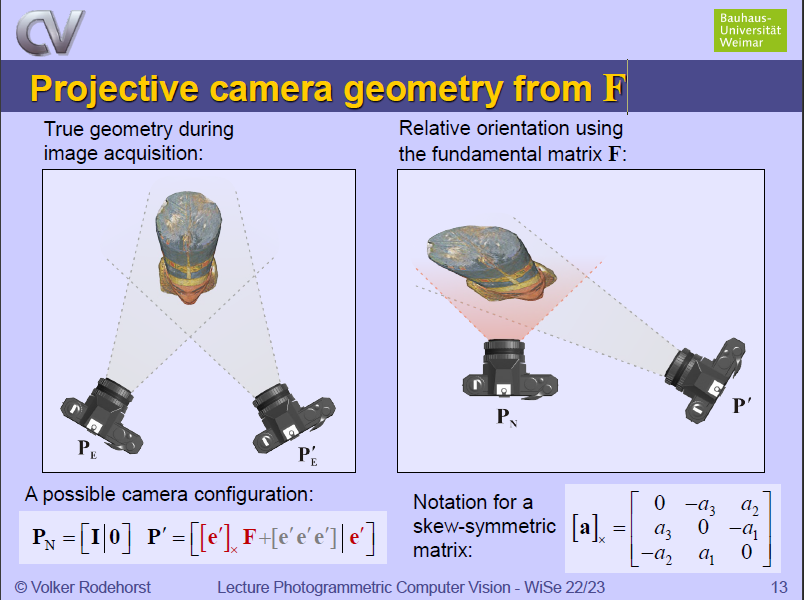

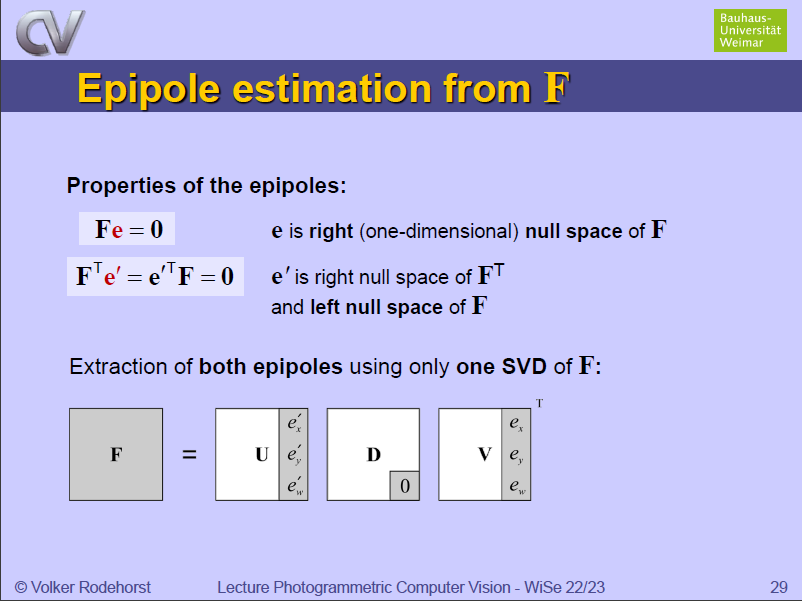

In [16]:
#Epipole estimation from F
def epipoles(Fundamental_matrix):
    U, S, V = svd(Fundamental_matrix)
    epi_1 = np.transpose(V)[:,-1] #third column
    epi_2 = U[:,-1]

In [17]:
# Singular value decomposition to find the epipoles
U, S, V = svd(Fundamental_matrix)
epi_1 = np.transpose(V)[:,-1] #third column
epi_2 = U[:,-1]

In [18]:
# Projection matrices
def projection_matrices(epi_2,Fundamental_matrix):
    # Normalized camera
    P_N = np.eye(3, 4)
    ex_skew_sym = [ [0,          -epi_2[2],      epi_2[1]],
                [epi_2[2],    0,            -epi_2[0]],
                [-epi_2[1],   epi_2[0],      0]]
    # Projective camera
    P_1 = np.c_[(np.matmul(ex_skew_sym, Fundamental_matrix))+ np.transpose(np.array([epi_2, epi_2, epi_2])), (epi_2)]
    return P_N, P_1


In [19]:
P_N, P_1 = (projection_matrices(np.transpose(epi_2),Fundamental_matrix))
print(f"First projectrion matrix: \n{P_N}\n")
print(f"Second projectrion matrix: \n{P_1}")

First projectrion matrix: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]

Second projectrion matrix: 
[[ 9.19015048e-01  9.19779896e-01  8.48503495e-01  9.17019265e-01]
 [-3.94253843e-01 -3.92495313e-01 -5.56363763e-01 -3.98842554e-01]
 [ 5.36590979e-04  5.30529179e-04  8.26120433e-03  5.33120305e-04]]


#### Now let's calculates Calibration matrices from the calculated projection matrices (P_N and P_1)

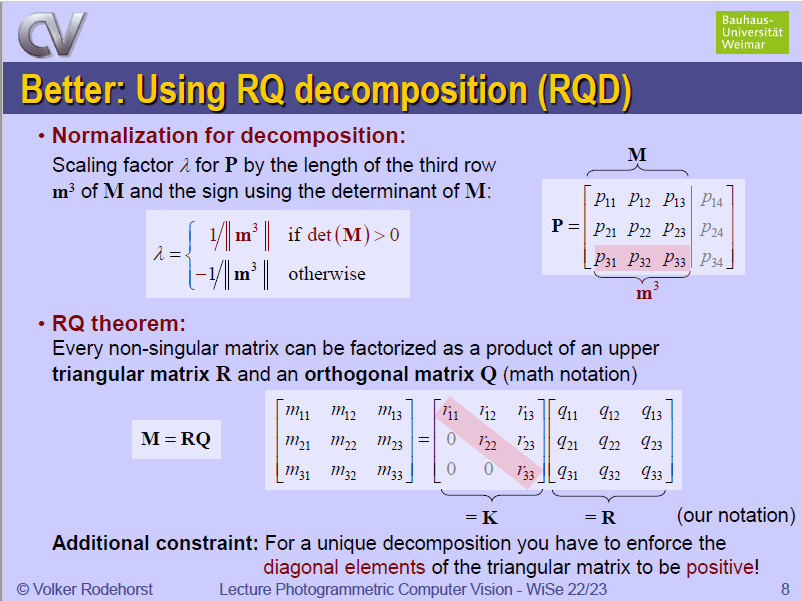

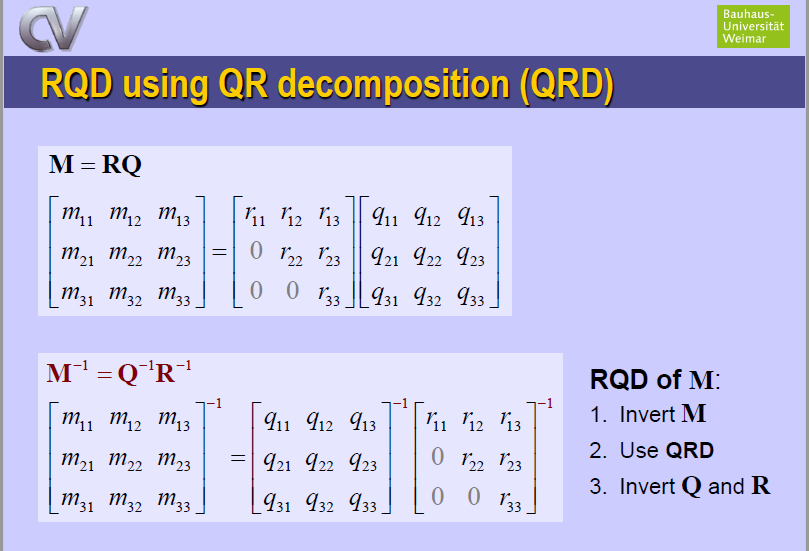

In [20]:
def RQDecomposition(projection_matrix):
    # M = First 3*3 part of Projection matrix
    M = projection_matrix[:,0:3]
    # normalize
    M= M/np.linalg.norm(M[2,:])
    # Determinant of M
    det_M = np.linalg.det(M)
    if (det_M<0):
        M = -M
    # RQD using QR decomposition(QRD)
    Q,R = qr(np.linalg.inv(M))
    Q = np.linalg.inv(Q)
    R = np.linalg.inv(R)
#     print(Q)
#     print(R)
    sign = np.sign(np.diagonal(R))
#     print(sign)
    # invert R and S
    R = R*np.diag(np.diag(sign))
    Q = np.diag(np.diag(sign))*Q
    return R, Q

In [21]:
K1, R1 = RQDecomposition(P_N)
np.set_printoptions(suppress=False)
print(f"Calibration Matrix 1: \n{K1}")
#print(R1)

Calibration Matrix 1: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [22]:
K2, R2 = RQDecomposition(P_1)
np.set_printoptions(suppress=False)
print(f"Calibration Matrix 2: \n{K2}")

Calibration Matrix 2: 
[[   0.3966661  -146.78277603  116.11635216]
 [   0.           60.68322682  -72.88934646]
 [   0.            0.            1.        ]]


### b) Based on the computed calibration matrices estimate the essential matrix, that relates the two view.

In [23]:
print("The calibration Matrices are:\n")
print(f"Calibration Matrix 1: \n{K1}\n")
print(f"Calibration Matrix 2: \n{K2}")

The calibration Matrices are:

Calibration Matrix 1: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Calibration Matrix 2: 
[[   0.3966661  -146.78277603  116.11635216]
 [   0.           60.68322682  -72.88934646]
 [   0.            0.            1.        ]]


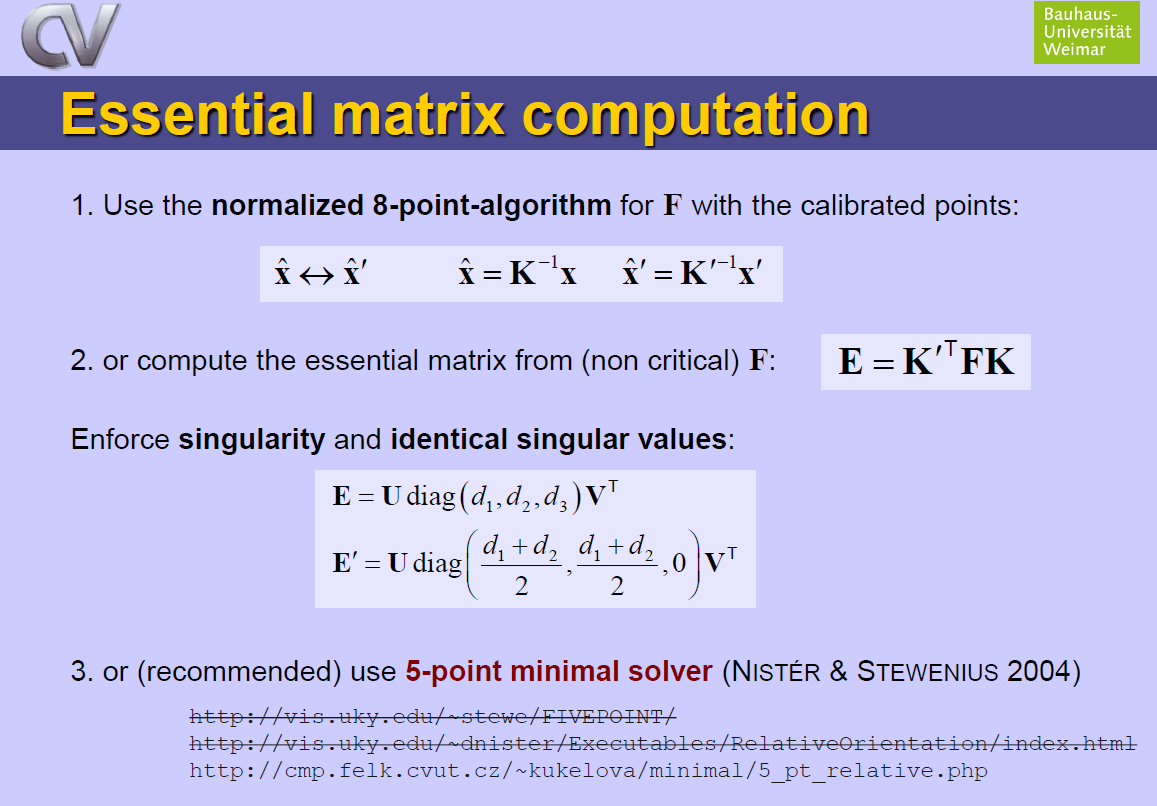

In [24]:
print(f"Fundamental_matrix: \n {Fundamental_matrix}")

Fundamental_matrix: 
 [[ 3.83058773e-06  2.35039174e-06  2.99831101e-03]
 [ 2.11868312e-06 -3.84785983e-06  7.12332908e-03]
 [-5.00393952e-03 -6.92159860e-03  1.71776988e-01]]


There are 3 methods mentioned
1. Use the normalized 8-point-algorithm for F with the calibrated points
2. compute the essential matrix from(non critical)F
3. use 5-point minimal solver

Let's start with first one:

#### Method 1: normalized 8-point-algorithm for F with the calibrated points

In [25]:
# assign (x,y) coordinate values to each images
print(x1)
print(x2)

[[300. 310. 290. ... 260. 240. 250.]
 [502. 502. 492. ...  42.  32.  32.]
 [  1.   1.   1. ...   1.   1.   1.]]
[[401.81 406.34 394.1  ... 265.27 247.34 256.23]
 [457.46 457.82 446.43 ...  44.6   35.13  35.66]
 [  1.     1.     1.   ...   1.     1.     1.  ]]


In [26]:
# calibrated points
x_1hat = np.matmul(np.linalg.inv(K1),x1)
x_2hat = np.matmul(np.linalg.inv(K2),x2)

In [27]:
x_1hat

array([[300., 310., 290., ..., 260., 240., 250.],
       [502., 502., 492., ...,  42.,  32.,  32.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.]])

In [28]:
x_2hat

array([[3.95426218e+03, 3.96787762e+03, 3.86756518e+03, ...,
        1.09245815e+03, 9.89509150e+02, 1.01515284e+03],
       [8.73963654e+00, 8.74556899e+00, 8.55787297e+00, ...,
        1.93610908e+00, 1.78005278e+00, 1.78878666e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [29]:
# identical singular values and singularity constraint constraint
def identicalSingular_singularityConstraint(Essential_Matrix):
    U, S, V = svd(Essential_Matrix)
    # identical singular values constraint
    temp = (S[0]+S[1])/2
    S[0] = temp 
    S[1] = temp
    S[-1] = 0
    S = np.diag(S)
    Essential_Matrix_final = np.matmul(np.matmul(U, S), (V))
    return Essential_Matrix_final

In [30]:
# Essential matrix computation
def EssentialMatrixComputation(x1, x2):
    # Conditioning of the points on the first image plane
    T1 = conditioning(x1)
    # Conditioning of the points on the second image plane
    T2 = conditioning(x2)
    x1_transformed = np.matmul(T1, x1)
    x2_transformed = np.matmul(T2, x2)
    design_matrix = design_matrix_calc(x1_transformed, x2_transformed)
    E_conditioned = SVD_solv(design_matrix).reshape((3, 3))
    Essential_matrix = np.matmul(np.matmul(np.transpose(T2), E_conditioned), T1)
    return Essential_matrix

In [31]:
Essential_Matrix1 = EssentialMatrixComputation(x_1hat,x_2hat)
print(f"Essential Matrix: \n{Essential_Matrix1}")

Essential Matrix: 
[[ 1.09556333e-06  6.74599983e-07  8.58608805e-04]
 [-3.12672605e-04 -4.18251982e-04 -5.67243762e-03]
 [-3.40190018e-03 -4.59711819e-03  4.28457117e-04]]


In [32]:
Essential_Matrix1_Final = identicalSingular_singularityConstraint(Essential_Matrix1)
print(f"Essential Matrix: \n{Essential_Matrix1_Final}")

Essential Matrix: 
[[-2.94504269e-06 -4.62511208e-06  8.57883784e-04]
 [-2.86784762e-04 -3.83253801e-04 -5.66365519e-03]
 [-3.40711332e-03 -4.60419773e-03  4.72492290e-04]]


In [33]:
def constraints_check(Essential_Matrix):
    print(f"Singularity constraint check: det(E) = {np.linalg.det(Essential_Matrix)}\n")
    print("Trace Constraint check: ")
    multiply_E_ET = np.matmul(Essential_Matrix,np.transpose(Essential_Matrix))
    trace1 = np.matrix.trace(multiply_E_ET)
    print(f"{2*np.matmul(multiply_E_ET,Essential_Matrix)-(trace1*Essential_Matrix)}\n")
    print("Check if the first two singular values are identical: ")
    U, S, V = svd(Essential_Matrix)
    print(f"Diagonal matrix: {S}")

In [34]:
constraints_check(Essential_Matrix1_Final)

Singularity constraint check: det(E) = -3.869416680215719e-25

Trace Constraint check: 
[[-5.68686671e-24 -6.10045702e-24 -6.61744490e-24]
 [ 3.63959470e-23  4.96308368e-23  1.05879118e-22]
 [-2.64697796e-23 -5.29395592e-23  5.29395592e-23]]

Check if the first two singular values are identical: 
Diagonal matrix: [5.74771349e-03 5.74771349e-03 2.60845078e-19]


#### Method 2: compute the essential matrix from (non critical) F 

In [35]:
# Before applying constraints
Essential_Matrix2 = np.matmul(np.matmul(np.transpose(K2), Fundamental_matrix), K1)
print(f"Essential Matrix: \n{Essential_Matrix2}")

Essential Matrix: 
[[ 1.51946430e-06  9.32320728e-07  1.18932834e-03]
 [-4.33695772e-04 -5.78497576e-04 -7.83381906e-03]
 [-4.71357507e-03 -6.36821169e-03  7.15123819e-04]]


In [36]:
# identity singular and singularity constraint 
Essential_Matrix2_Final = identicalSingular_singularityConstraint(Essential_Matrix2)
print(f"Essential Matrix: \n{Essential_Matrix2_Final}")

Essential Matrix: 
[[ 1.51946430e-06  9.32320729e-07  1.18932834e-03]
 [-4.33695772e-04 -5.78497576e-04 -7.83381906e-03]
 [-4.71357507e-03 -6.36821169e-03  7.15123819e-04]]


In [37]:
constraints_check(Essential_Matrix2_Final)

Singularity constraint check: det(E) = 3.7410958459873012e-25

Trace Constraint check: 
[[-3.87740912e-25 -1.34416850e-24 -7.94093388e-23]
 [-1.98523347e-23 -1.32348898e-23  4.23516474e-22]
 [-2.11758237e-22 -3.17637355e-22 -1.32348898e-23]]

Check if the first two singular values are identical: 
Diagonal matrix: [7.95579316e-03 7.95579316e-03 1.88440309e-18]


### c) Resolve the fourfold ambiguity of the essential matrix by selecting the geometrically plausible solution.

When you compute the essential matrix, it is possible to obtain four possible solutions due to the inherent four-fold ambiguity in the matrix. However, only one of these solutions is the correct reconstruction that satisfies the epipolar constraint and has the reconstructed point in front of both cameras.

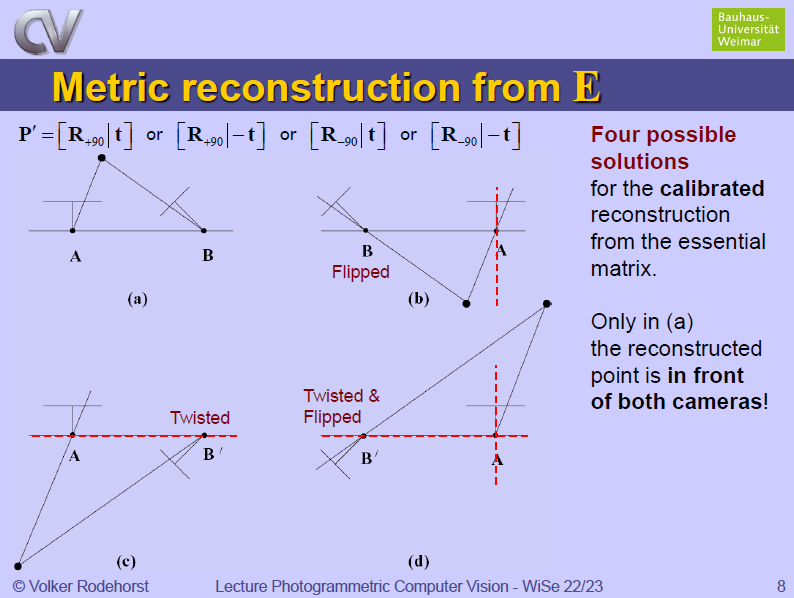

Reference: Recovery of R,T from Essential Matrix, University of California, Berkeley
    
Link: [Recovery of R,T from Essential Matrix](https://inst.eecs.berkeley.edu/~ee290t/fa19/lectures/lecture10-3-decomposing-F-matrix-into-Rotation-and-Translation.pdf)


#### To find the correct combination of Rotation and translation matrix, we need to check if the To check if the reconstructed 3D point is in front of both cameras. For this, we can transform it into camera coordinates using the extrinsic parameters (rotation and translation matrices) and then check its depth. The depth of a point in camera coordinates is given by the third component of the transformed point.

#### If the depth is positive, then the point is in front of the camera. If the depth is negative, then the point is behind the camera. If the depth is zero, then the point is on the camera plane.

In [38]:
# Read the control point information from the provided file pp.dat
from numpy import *
control_point = loadtxt('pp.dat')
x1_c = control_point[:,0:2]
x2_c = control_point[:,2:4]
XE = control_point[:,4:7] # euclidean object points

In [39]:
XE = (np.c_[XE, np.transpose(np.ones(XE.shape[0]))])

In [40]:
# select one object point to check if it lies in front of both cameras/ positive depth for all points
Object_point = XE[0]
Object_point = Object_point.reshape((4,1))
Object_point.shape

(4, 1)

Compute the SVD of the essential matrix E = USV^T.

Determine the rotation matrix R from the rotation part of the SVD, which is R = UWV^T or R = UW^TV^T.

Determine the translation vector t from the translation part of the SVD, which is either t = u3 or t = -u3, where u3 is the third column of U.

In [41]:
def fourfold_ambiguity(E):

    # Given object points in homogeneous coordinates
    X_hom = [Object_point]

    # Singular value decomposition of essential matrix
    U, S, V = np.linalg.svd(E)

    # Possible rotation matrices
    R1 = U @ np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]) @ V.T
    R2 = U @ np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]]) @ V.T
    R3 = U @ np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]]) @ V.T
    R4 = U @ np.array([[-1, 0, 0], [0, 1, 0], [0, 0, -1]]) @ V.T

    # Possible translation vectors
    t1 = (U[:, 2])
    t2 = -U[:, 2]
    t3 = U[:, 2]
    t4 = -U[:, 2]

    # Check which combination gives positive depth for all points
    for R, t in [(R1, t1), (R2, t2), (R3, t3), (R4, t4)]:
        positive_depth = True
        for x in X_hom:
            # transform to camera coordinates
            x_camera_coordinates = np.dot(R, x[:3]) + t

            # calculate depth in camera coordinates
            depth = x_camera_coordinates[2]

            if (depth < 0).all():
                positive_depth = False
                break

        if positive_depth:
            # correct combination found
            print("Correct combination found")
            print(f"Rotation matrix: \n{R}")
            print(f"Translation vector: \n{t}")
            return(R,t)
            break
    else:
        # no combination gives positive depth for all points
        print("No correct combination found")

In [42]:
# Given essential matrix
# Essential matrix obtained from 2 methods are:
E1 = Essential_Matrix1_Final
print(f"Essential Matrix: \n{E1}\n")
R1,t1 = fourfold_ambiguity(E1)

Essential Matrix: 
[[-2.94504269e-06 -4.62511208e-06  8.57883784e-04]
 [-2.86784762e-04 -3.83253801e-04 -5.66365519e-03]
 [-3.40711332e-03 -4.60419773e-03  4.72492290e-04]]

Correct combination found
Rotation matrix: 
[[-0.9889101   0.11886514 -0.08903875]
 [-0.14791817 -0.84200829  0.51878922]
 [ 0.01330542 -0.52620635 -0.85025281]]
Translation vector: 
[-0.98879805 -0.14865977  0.01336774]


In [43]:
E2 = Essential_Matrix2
print(f"Essential Matrix: \n{E2}\n")
R2,t2 = fourfold_ambiguity(E2)

Essential Matrix: 
[[ 1.51946430e-06  9.32320728e-07  1.18932834e-03]
 [-4.33695772e-04 -5.78497576e-04 -7.83381906e-03]
 [-4.71357507e-03 -6.36821169e-03  7.15123819e-04]]

Correct combination found
Rotation matrix: 
[[ 0.90158802  0.41408378  0.12519448]
 [ 0.30010954 -0.39026843 -0.87041646]
 [-0.31156589  0.82232912 -0.47613183]]
Translation vector: 
[-0.98876289 -0.14889223  0.01338083]


### d) Compute and plot the epipolar lines from the essential matrix.

In [44]:
x1_c = np.transpose(np.c_[x1_c, np.transpose(np.ones(x1_c.shape[0]))])
x2_c = np.transpose(np.c_[x2_c, np.transpose(np.ones(x2_c.shape[0]))])
x1_c.shape

(3, 5)

In [45]:
def plot_lines(x1,epi_line):
    x = np.linspace(0,6000)
    for i in range(epi_line.shape[1]):
        line = epi_line[:,i]
        x_intercept = (-line[2]/line[0])
        y_intercept = (-line[2]/line[1])
        slope = -y_intercept/x_intercept
        plt.plot(x,slope*x+y_intercept)
        plt.plot(x1[:,i][0], x1[:,i][1], marker="*", markersize=2, color="red")
    plt.axis('off')
    #plt.imshow(img)
    plt.show()

In [46]:
# Essential to epipolar lines 
def essentialMatrixToEpipolar(R,t):
    P_new = np.hstack((R, t.reshape(3,1)))
    Knew, Rnew = RQDecomposition(P_new)
    # calibrated points
    x_1hat = np.matmul(np.linalg.inv(K1),x1)
    x_2hat_new = np.matmul(np.linalg.inv(Knew),x2)
    Essential_Matrix_new = EssentialMatrixComputation(x_1hat,x_2hat_new)
    print(f"{Essential_Matrix_new}")
    Essential_Matrix_Final = identicalSingular_singularityConstraint(Essential_Matrix_new)
    print(f"{Essential_Matrix_Final}")
    epi_line1 = np.matmul(np.transpose(Essential_Matrix_Final),x2_c)
    epi_line2 = np.matmul(Essential_Matrix_Final,x1_c)
    plot_lines(x1_c,epi_line1)
    plot_lines(x2_c,epi_line2)
    return P_new, Essential_Matrix_Final

[[ 3.82482678e-06  2.35260761e-06  2.99926501e-03]
 [ 2.12149836e-06 -3.84894268e-06  7.12286288e-03]
 [-5.00284406e-03 -6.92201995e-03  1.71595583e-01]]
[[ 0.02036537  0.02751669  0.00320318]
 [ 0.04680227  0.06323682  0.00747695]
 [-0.00479996 -0.00656702  0.08579778]]


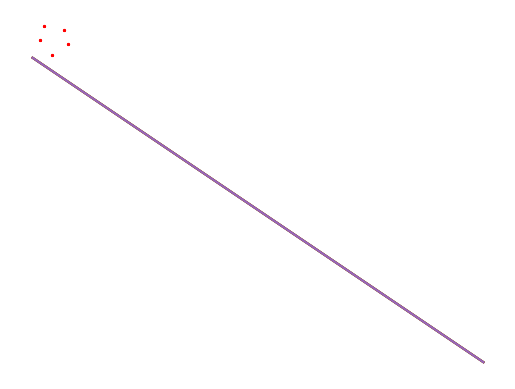

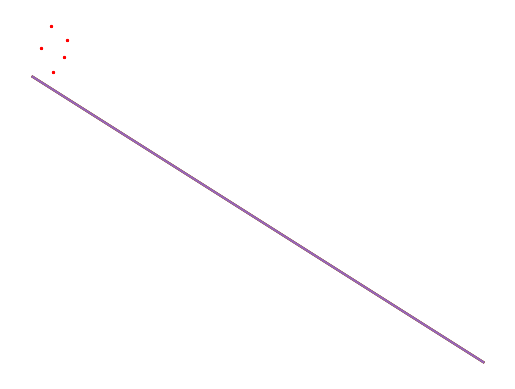

In [47]:
P_new1, Essential_Matrix_Final1 = essentialMatrixToEpipolar(R1,t1)

## Task 2 – Non-linear Optimization: 

Singular value decomposition (SVD) provides an optimal solution with respect to the algebraic error. The goal, however, is to obtain a solution optimal with respect to the geometric error. The algebraic solution can
serve as a starting point for further non-linear optimization.

In [48]:
# selected the Essential matrix obtained from using 8-point normalized algorithm
Essential_Matrix_ = Essential_Matrix_Final1
Essential_Matrix_

array([[ 0.02036537,  0.02751669,  0.00320318],
       [ 0.04680227,  0.06323682,  0.00747695],
       [-0.00479996, -0.00656702,  0.08579778]])

### a) Compute the geometric error based on the solution from Task 1.

In [49]:
def Geometric_error(x1,x2,Essential_Matrix_):
    epi_line1 = np.matmul(np.transpose(Essential_Matrix_),x2)
    epi_line2 = np.matmul(Essential_Matrix_,x1)
    numerator = sum((np.multiply(x2,epi_line2)))**2
    denominator = (epi_line2[0,:]**2)+(epi_line2[1,:]**2)+(epi_line1[0,:]**2)+(epi_line1[1,:]**2)
    error = np.mean(np.divide(numerator,denominator))
    print(f"Geometric_error : {error}")
    return error

In [50]:
# geometric error for 5 points
Error_5points = Geometric_error(x1_c,x2_c,Essential_Matrix_)

Geometric_error : 3725173.0714733587


In [51]:
# Geometric error for all points
Error_allpoints = Geometric_error(x1,x2,Essential_Matrix_)

Geometric_error : 199992063287.54926


### b) Perform a non-linear optimization by means of the indirect optimization using a built-in function of your choice (Levenberg-Marquart, etc.).

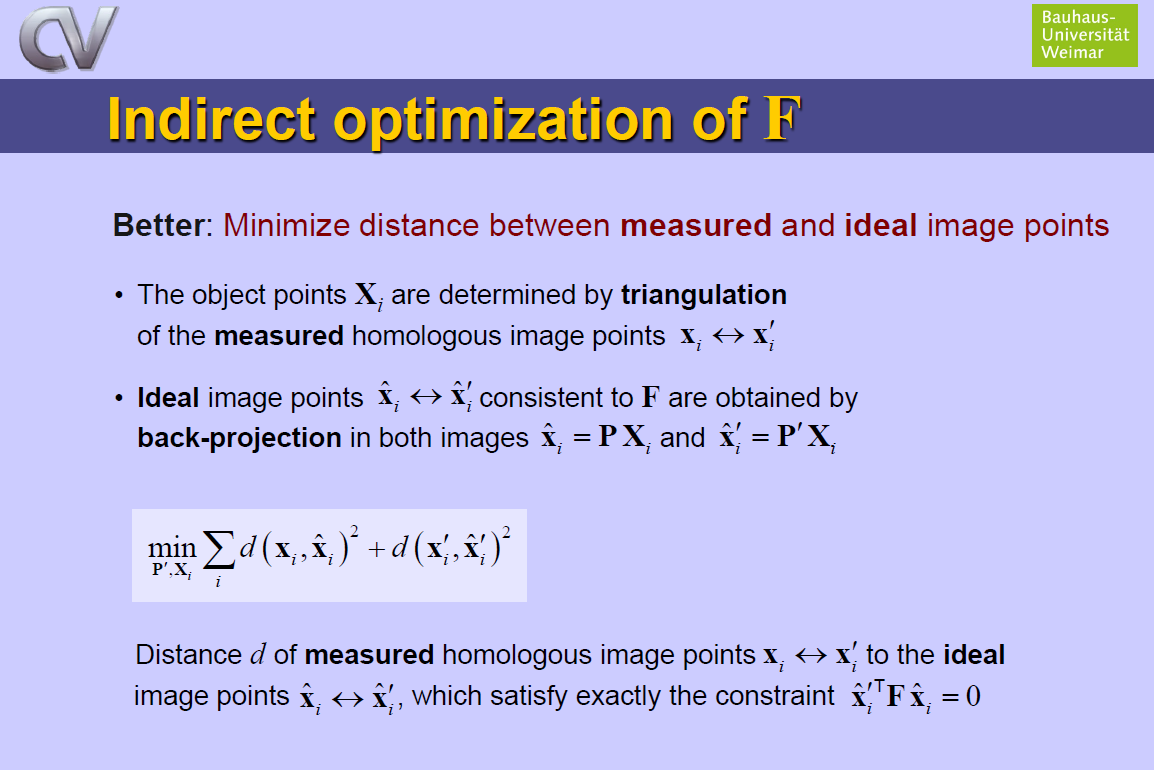

#### Method: Minimize distance between measuredand idealimage points

In [52]:
# Linear triangulation
def linear_triangulation(P_N, P_1, x1, x2):
    X = np.zeros([4,x1.shape[1]])
    for i in range(x1.shape[1]):
        Design_matrix = np.array([x1[0,i] * P_N[2,:] - P_N[0,:],
                        x1[1,i] * P_N[2,:] - P_N[1,:],
                        x2[0,i] * P_1[2,:] - P_1[0,:],
                        x2[1,i] * P_1[2,:] - P_1[1,:]])
        
        X[:,i] = euclidean_normalization(SVD_solv(Design_matrix))
    return X    

In [53]:
# Singular value decomposition
def SVD_solv(design_matrix):
# u, s, vh = np.linalg.svd(d, full_matrices=True)
    U, S, V = svd(design_matrix)
    # return last row of V
    return V[-1]

In [54]:
def euclidean_normalization(X):
    return X/X[-1]

In [55]:
def sum_of_squares_(x1_c,x1_new):
    distances = np.sqrt(np.sum((x1_c - x1_new)**2, axis=0))
    sum_of_squares = np.sum(distances**2)
    return sum_of_squares

In [56]:
def cost_function(P_1):
    P_1 = P_1.reshape((3, 4))
    X = linear_triangulation(P_N, P_1, x1, x2)
    x1_new = np.matmul(P_N,X)
    x1_new = x1_new/x1_new[-1]
    x2_new = np.matmul(P_1,X)
    x2_new = x2_new/x2_new[-1]
    distance = sum_of_squares_(x1,x1_new) + sum_of_squares_(x2,x2_new)
    #print(f"distance : {distance}")
    return distance

In [57]:
from scipy.optimize import least_squares

#x1 = x1_c
#x2 = x2_c

# initial guess for P_1 parameters
P_1_reshape = P_1.reshape(-1)

# perform optimization using least squares (Levenberg-Marquart)
res = least_squares(cost_function, P_1_reshape)

# obtain optimized parameters for P_1
P_1_opt = res.x.reshape((3, 4))

print(P_1_opt)

[[ 9.19015048e-01  9.19779896e-01  8.48503495e-01  9.17019265e-01]
 [-3.94253843e-01 -3.92495313e-01 -5.56363763e-01 -3.98842554e-01]
 [ 5.36590979e-04  5.30529179e-04  8.26120433e-03  5.33120305e-04]]


In [58]:
K_opti, Ropti = RQDecomposition(P_1_opt)
np.set_printoptions(suppress=False)
print(f"Calibration Matrix 2: \n{K_opti}")

Calibration Matrix 2: 
[[   0.3966661  -146.78277603  116.11635216]
 [   0.           60.68322682  -72.88934646]
 [   0.            0.            1.        ]]


In [59]:
x_1hat = np.matmul(np.linalg.inv(K1),x1)
x_2hat_new = np.matmul(np.linalg.inv(K_opti),x2)
Essential_Matrix_new = EssentialMatrixComputation(x_1hat,x_2hat_new)
#print(f"{Essential_Matrix_new}")
Essential_Matrix_Final = identicalSingular_singularityConstraint(Essential_Matrix_new)
print(f"Final Essential Matrix: \n{Essential_Matrix_Final}")

Final Essential Matrix: 
[[-2.94504269e-06 -4.62511208e-06  8.57883784e-04]
 [-2.86784762e-04 -3.83253801e-04 -5.66365519e-03]
 [-3.40711332e-03 -4.60419773e-03  4.72492290e-04]]


### d) Re-calculate the geometric error. Report and comment on the results.

In [60]:
# geometric error for 5 points
Error_5points_opti = Geometric_error(x1_c,x2_c,Essential_Matrix_Final)

Geometric_error : 2754771.3035694947


In [61]:
# Geometric error for all points
Error_allpoints_opti = Geometric_error(x1,x2,Essential_Matrix_Final)

Geometric_error : 142264210269.01727


In [62]:
print(f"Geometrical error before optimization: {Error_5points}")
print(f"Geometrical error after optimization: {Error_5points_opti}")

Geometrical error before optimization: 3725173.0714733587
Geometrical error after optimization: 2754771.3035694947


The geometrical error decreased after optimization.